## Generate mixture data

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(array([0.00614318, 0.04300225, 0.13514994, 0.20886809, 0.27029988,
        0.22115445, 0.12593517, 0.07064656, 0.09829087, 0.24879876,
        0.31023055, 0.26108511, 0.19965332, 0.0890761 , 0.04300225,
        0.03993066, 0.04914543, 0.08600451, 0.06450338, 0.10136246,
        0.10136246, 0.07986133, 0.09521928, 0.04914543, 0.03993066,
        0.01842954, 0.01228636, 0.        , 0.        , 0.00307159]),
 array([-1.50574075, -1.18017642, -0.85461209, -0.52904777, -0.20348344,
         0.12208089,  0.44764522,  0.77320955,  1.09877388,  1.4243382 ,
         1.74990253,  2.07546686,  2.40103119,  2.72659552,  3.05215984,
         3.37772417,  3.7032885 ,  4.02885283,  4.35441716,  4.67998149,
         5.00554581,  5.33111014,  5.65667447,  5.9822388 ,  6.30780313,
         6.63336745,  6.95893178,  7.28449611,  7.61006044,  7.93562477,
         8.2611891 ]),
 <a list of 30 Patch objects>)

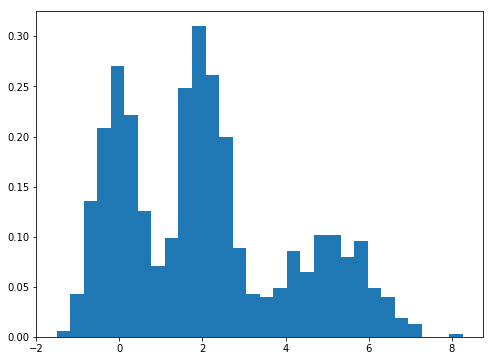

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

SEED = 383561
np.random.seed(SEED) # from random.org, for reproducibility

# Data Parameters
N = 1000
W = np.array([0.35, 0.4, 0.25])
MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=30, normed=True, lw=0)

In [ ]:
# Sampling Parameters
N_SAMPLES = 5000
BURN_IN = 1000
THINNING = 10

In [2]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [3]:
cb = [
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='absolute'),
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='relative'),
    ]

approx = pm.fit(
            random_seed=SEED,
            n=3, 
            method='advi', 
            model=model,
            callbacks=cb,
            obj_optimizer=pm.adagrad_window,
        )  # type: pm.MeanField
start = approx.sample(draws=1)
start = list(start)

Average Loss = 4,875.9: 100%|██████████| 3/3 [00:00<00:00, 459.77it/s]
Finished [100%]: Loss = 3,542


In [4]:
with model:
    _trace = pm.sample(N_SAMPLES, tune=BURN_IN, start=start)
    trace = _trace[::THINNING]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, mu, w_stickbreaking__]
100%|██████████| 6000/6000 [00:21<00:00, 279.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e677f90>,
      dtype=object)

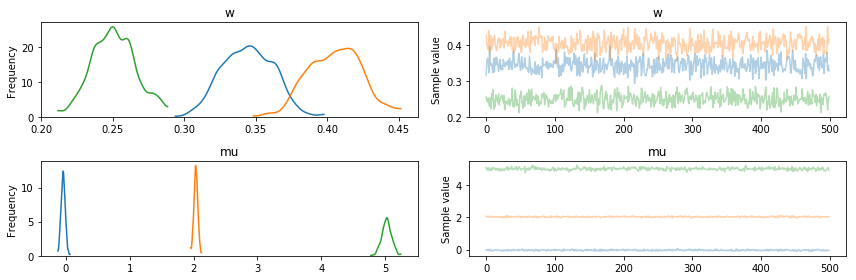

In [5]:
pm.traceplot(trace, varnames=['w', 'mu'])

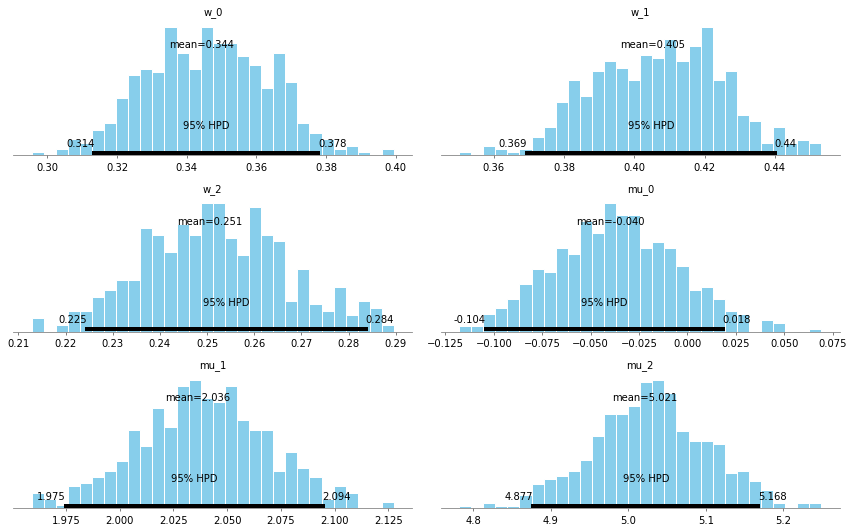

In [6]:
pm.plot_posterior(trace, varnames=['w', 'mu']);

100%|██████████| 5000/5000 [00:03<00:00, 1385.87it/s]


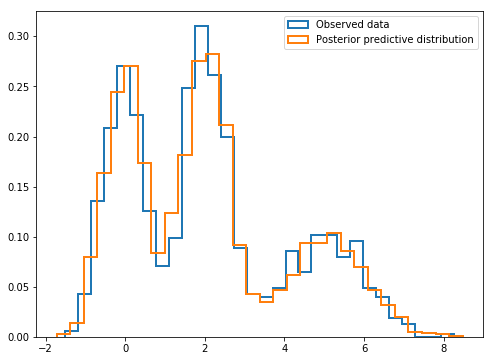

In [7]:
# We can also sample from the model’s posterior predictive distribution, as follows.
with model:
    ppc_trace = pm.sample_ppc(trace, 5000, random_seed=SEED)

# We see that the posterior predictive samples have a distribution quite close to that of the observed data.

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1)

## Run with SGFS

In [8]:
from collections import OrderedDict
import warnings

from pymc3.step_methods.arraystep import Competence, ArrayStepShared
from pymc3.vartypes import continuous_types
from pymc3.model import modelcontext, inputvars
import theano.tensor as tt
from pymc3.theanof import tt_rng, make_shared_replacements, jacobian, floatX, inputs
import theano
import numpy as np

__all__ = ['SGFS', 'CSG']

EXPERIMENTAL_WARNING = "Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet"\
    " recommended for use in PyMC3!"


def _value_error(cond, str):
    """Throws ValueError if cond is False"""
    if not cond:
        raise ValueError(str)


def _check_minibatches(minibatch_tensors, minibatches):
    _value_error(
        isinstance(minibatch_tensors, list),
        'minibatch_tensors must be a list.')

    _value_error(
        hasattr(minibatches, "__iter__"), 'minibatches must be an iterator.')


def get_model_hierarchy(model=None):
    """Calculates the hierarchichal relationships between variables
    
    Parameters
    ----------
    vars
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    hierarchy : dict
    """
    model = modelcontext(model)
    hierarchy = {}
    for rv in model.free_RVs:

        dist = None
        if hasattr(rv.distribution, 'transform_used') and rv.distribution.transform_used != None:
            dist = rv.distribution.dist
        else:
            dist = rv.distribution        

        inputs = []
        for var in model.named_vars.values():        
            if var in dist.__dict__.values() and hasattr(var, 'transformed'):
                inputs.append(var.transformed)
            elif var in dist.__dict__.values():
                inputs.append(var)

        hierarchy[rv] = inputs
    return hierarchy

def get_log_prior(vars=None, model=None):
    """Calculate the elementwise log-prior for the model.

    Parameters
    ----------
    vars
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    log_prior : [X]-D tensor
    """
    model = modelcontext(model)
    return tt.flatten(jacobian(tt.sum([v.logpt for v in vars]), vars))


def get_multi_obs_logp_elemwiset(vars=None, model=None):
    """Calculate the elementwise log-posterior for the model.
    Handle case when there are more than one observed RVs

    Parameters
    ----------
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    logp_elemwiset : array of shape (n_samples, n_observations)
        The contribution of the observations to the logp of the whole model.
    """
    model = modelcontext(model)
    cached = [(var, var.logp_elemwiset) for var in model.observed_RVs]

    if len(cached) == 0:
        return floatX(np.array([], dtype='d'))

    logp_elemwiset = []
    for var, logp in cached:
        if var.missing_values:
            logp = logp[~var.observations.mask]
        logp_elemwiset.append(logp.ravel())
        
    logp_elemwiset = tt.concatenate(logp_elemwiset, axis=1)
    return jacobian(logp_elemwiset, vars)


def get_elemwise_dlogL(vars=None, model=None, flat_view=None,):
    """
    Returns Jacobian of the log likelihood for each training datum wrt vars
    as a matrix of size N x D
    """
    # set model
    model = modelcontext(model)

    dlogp_elemwiset = get_multi_obs_logp_elemwiset(vars, model)    
    dlog_prior = get_log_prior(vars, model)        
    dlogL = dlogp_elemwiset + dlog_prior
    
    if flat_view is not None:
        
        dlogp_elemwiset = theano.clone(dlogp_elemwiset, flat_view.replacements, strict=False)
        dlog_prior = theano.clone(dlog_prior, flat_view.replacements, strict=False)
        dlogL = theano.clone(dlogL, flat_view.replacements, strict=False)

    return dlogp_elemwiset, dlog_prior, dlogL


class BaseStochasticGradient(ArrayStepShared):
    R"""
    BaseStochasticGradient Object

    For working with BaseStochasticGradient Object
    we need to supply the probabilistic model
    (:code:`model`) with the data supplied to observed
    variables of type `GeneratorOp`

    Parameters
    ----------
    vars : list
        List of variables for sampler
    batch_size`: int
        Batch Size for each step
    total_size : int
        Total size of the training data
    step_size : float
        Step size for the parameter update
    model : PyMC Model
        Optional model for sampling step. Defaults to None (taken from context)
    random_seed : int
        The seed to initialize the Random Stream
    minibatches : iterator
        If the ObservedRV.observed is not a GeneratorOp then this parameter must not be None
    minibatch_tensor : list of tensors
        If the ObservedRV.observed is not a GeneratorOp then this parameter must not be None
        The length of this tensor should be the same as the next(minibatches)

    Notes
    -----
    Defining a BaseStochasticGradient needs
    custom implementation of the following methods:
        - :code: `.mk_training_fn()`
            Returns a theano function which is called for each sampling step
        - :code: `._initialize_values()`
            Returns None it creates class variables which are required for the training fn
    """

    def __init__(self,
                 vars=None,
                 batch_size=None,
                 total_size=None,
                 step_size=None,
                 step_size_decay=None,
                 model=None,
                 random_seed=None,
                 minibatches=None,
                 minibatch_tensors=None,
                 **kwargs):
        warnings.warn(EXPERIMENTAL_WARNING)

        model = modelcontext(model)

        if vars is None:
            vars = model.vars

        vars = inputvars(vars)
        self.kwargs = kwargs
        self.model = model
        self.vars = vars
        self.batch_size = batch_size
        self.total_size = total_size
        _value_error(
            total_size != None or batch_size != None,
            'total_size and batch_size of training data have to be specified')
        self.expected_iter = int(total_size / batch_size)

        # set random stream
        self.random = None
        if random_seed is None:
            self.random = tt_rng()
        else:
            self.random = tt_rng(random_seed)
        
        if step_size is None:
            step_size = np.sqrt(float(batch_size) / total_size)
        
        if step_size is None:
            step_size = 1.0 / total_size
            
        self.step_size = step_size

        shared = make_shared_replacements(vars, model)

        self.updates = OrderedDict()
        self.q_size = int(sum(v.dsize for v in self.vars))

        flat_view = model.flatten(vars)
        self.inarray = [flat_view.input]

        self.dlogp_elemwise, self.dlog_prior, self.dlogL_elemwise = get_elemwise_dlogL(vars, model, flat_view)
        
        self.q_size = int(sum(v.dsize for v in self.vars))

        if minibatch_tensors != None:
            _check_minibatches(minibatch_tensors, minibatches)
            self.minibatches = minibatches

            # Replace input shared variables with tensors
            def is_shared(t):
                return isinstance(t, theano.compile.sharedvalue.SharedVariable)

            tensors = [(t.type() if is_shared(t) else t)
                       for t in minibatch_tensors]
            updates = OrderedDict({
                t: t_
                for t, t_ in zip(minibatch_tensors, tensors) if is_shared(t)
            })
            self.minibatch_tensors = tensors
            self.inarray += self.minibatch_tensors
            self.updates.update(updates)

        self._initialize_values()
        super(BaseStochasticGradient, self).__init__(vars, shared)

    def _initialize_values(self):
        """Initializes the parameters for the stochastic gradient minibatch
        algorithm"""
        raise NotImplementedError

    def mk_training_fn(self):
        raise NotImplementedError

    def training_complete(self):
        """Returns boolean if astep has been called expected iter number of times"""
        return self.expected_iter == self.t

    def astep(self, q0):
        """Perform a single update in the stochastic gradient method.

        Returns new shared values and values sampled
        The size and ordering of q0 and q must be the same
        Parameters
        -------
        q0: list
            List of shared values and values sampled from last estimate

        Returns
        -------
        q
        """
        if hasattr(self, 'minibatch_tensors'):
            return q0 + self.training_fn(q0, *next(self.minibatches))
        else:
            return q0 + self.training_fn(q0)

class SGFS(BaseStochasticGradient):
    R"""
    StochasticGradientFisherScoring

    Parameters
    ----------
    vars : list
        model variables
    B : np.array
        the pre-conditioner matrix for the fisher scoring step
    step_size_decay : int
        Step size decay rate. Every `step_size_decay` iteration the step size reduce 
        to the half of the previous step size
 
    References
    ----------
    -   Bayesian Posterior Sampling via Stochastic Gradient Fisher Scoring
        Implements Algorithm 1 from the publication http://people.ee.duke.edu/%7Elcarin/782.pdf
    """
    name = 'stochastic_gradient_fisher_scoring'

    def __init__(self, vars=None, B=None, **kwargs):
        """
        Parameters
        ----------
        vars : list
            Theano variables, default continuous vars
        B : np.array
            Symmetric positive semi-definite Matrix
        kwargs: passed to BaseHMC
        """
        self.B = B       
        self.step_size_decay = kwargs.get('step_size_decay', 0.01)
        super(SGFS, self).__init__(vars, **kwargs)

    def _initialize_values(self):
        # Init avg_I
        self.avg_I = theano.shared(
            np.zeros((self.q_size, self.q_size)), name='avg_I')
        self.t = theano.shared(1, name='t')
        # 2. Set gamma
        self.gamma = (self.batch_size + self.total_size) / (self.total_size)
        self.training_fn = self.mk_training_fn()
    
    def mk_training_fn(self):

        n = self.batch_size
        N = self.total_size
        q_size = self.q_size
        B = self.B
        gamma = self.gamma
        avg_I = self.avg_I
        t = self.t
        updates = self.updates
        epsilon = self.step_size / (1.0 + self.step_size_decay*t)
        random = self.random
        inarray = self.inarray
        gt, dlog_prior = self.dlogL_elemwise, self.dlog_prior

        # 5. Calculate mean dlogp
        avg_gt = gt.mean(axis=0)

        # 6. Calculate approximate Fisher Score
        gt_diff = (gt - avg_gt)

        V = (1. / (n - 1)) * tt.dot(gt_diff.T, gt_diff)

        # 7. Update moving average
        I_t = (1. - 1. / t) * avg_I + (1. / t) * V

        if B is None:
            # if B is not specified
            # B \propto I_t as given in
            # http://www.ics.uci.edu/~welling/publications/papers/SGFS_v10_final.pdf
            # after iterating over the data few times to get a good approximation of I_N
            B = tt.switch(t <= int(N / n) * 50, tt.eye(q_size), gamma * I_t)

        # 8. Noise Term
        # The noise term is sampled from a normal distribution
        # of mean 0 and std_dev = sqrt(4B/step_size)
        # In order to generate the noise term, a standard
        # normal dist. is scaled with 2B_ch/sqrt(step_size)
        # where B_ch is cholesky decomposition of B
        # i.e. B = dot(B_ch, B_ch^T)
        B_ch = tt.slinalg.cholesky(B)
        noise_term = tt.dot((2.*B_ch)/tt.sqrt(epsilon), random.normal(size=(q_size,), dtype=theano.config.floatX))
        
        # 9.
        # Inv. Fisher Cov. Matrix
        cov_mat = (gamma * I_t * N) + ((4. / epsilon) * B)
        inv_cov_mat = tt.nlinalg.matrix_inverse(cov_mat)
        # Noise Coefficient
        noise_coeff = (dlog_prior + (N * avg_gt)) + noise_term
        dq = 2 * tt.dot(inv_cov_mat, noise_coeff)

        updates.update({avg_I: I_t, t: t + 1})

        f = theano.function(
            outputs=dq,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)
        
        return f

    @staticmethod
    def competence(var, has_grad):
        if var.dtype in continuous_types and has_grad:
            return Competence.COMPATIBLE
        return Competence.INCOMPATIBLE

In [24]:
batch_size = 100
x_minibatch = pm.Minibatch(x, batch_size=batch_size)
total_size = batch_size * N_SAMPLES

with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x_minibatch)

In [28]:
cb = [
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='absolute'),
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='relative'),
    ]

approx = pm.fit(
            random_seed=SEED,
            n=3, 
            method='advi', 
            model=model,
            callbacks=cb,
            obj_optimizer=pm.adagrad_window,
        )  # type: pm.MeanField
start = approx.sample(draws=1)[0]

Average Loss = 452.73: 100%|██████████| 3/3 [00:00<00:00, 603.99it/s]
Finished [100%]: Loss = 304.12


In [29]:
with model:
    step_method = SGFS(batch_size=batch_size, total_size=total_size)
    _trace = pm.sample(draws=N_SAMPLES, step=step_method, tune=BURN_IN, start=start, njobs=2)
    trace = _trace[::THINNING]

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/ipykernel_launcher.py:180: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
Multiprocess sampling (2 chains in 2 jobs)
SGFS: [tau_log__, mu, w_stickbreaking__]
100%|██████████| 6000/6000 [01:14<00:00, 80.18it/s]


# Test a few decay techniques

In [7]:
trace[15]

{'mu': array([0.33319713, 4.71775039, 1.73351324]),
 'tau': array([1.02359726, 0.96838001, 1.02893369]),
 'tau_log__': array([ 0.02332314, -0.03213069,  0.02852301]),
 'w': array([0.34033538, 0.31333344, 0.34633118]),
 'w_stickbreaking__': array([ 0.03134718, -0.10012754])}

In [9]:
len(trace)

500

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115c70d50>,
      dtype=object)

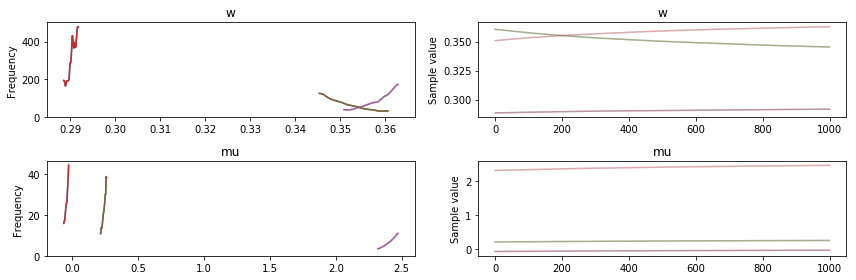

In [14]:
pm.traceplot(trace, varnames=['w', 'mu'])

In [ ]:
N = 1000
W = np.array([0.35, 0.4, 0.25])
MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

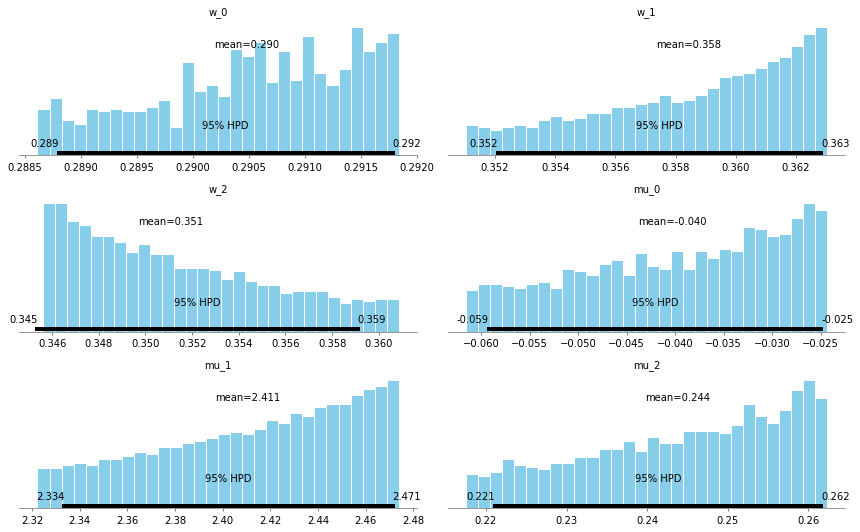

In [15]:
pm.plot_posterior(trace, varnames=['w', 'mu']);

In [404]:
trace[1]

{'mu': array([0.00969387, 0.01008507, 0.00960096]),
 'tau': array([0.98435541, 0.98418055, 0.98434127]),
 'tau_log__': array([-0.01576826, -0.01594591, -0.01578262]),
 'w': array([0.33335586, 0.33340357, 0.33324057]),
 'w_stickbreaking__': array([0.00010139, 0.000489  ])}

In [386]:
trace = [model.bijection.map(start)]
for _ in range(1):
    dlogL_elemwise, dlog_prior, avg_gt, V, B, noise_term, I_t, dq = step_method.astep(q0=trace[-1])
    break
    trace.append(sampled)

In [414]:
# epsilon noise effect
print(step_method.step_size)
epsilon = step_method.step_size / pow(2.0, 1 // step_method.step_size_decay)
print(epsilon)

1e-05
1e-05


In [415]:
N = total_size
# Inv. Fisher Cov. Matrix
cov_mat = (I_t * total_size) + ((4. / epsilon) * B)
inv_cov_mat = np.linalg.inv(cov_mat)
print(inv_cov_mat)

[[ 2.31034711e-06 -2.07687360e-08  3.40178831e-08  1.51724467e-07
   1.56144867e-08  7.42227375e-08 -7.24841086e-08 -2.39684107e-08]
 [-2.07687360e-08  2.47014314e-06 -1.21020512e-07  2.56585320e-08
   1.04654137e-08  7.51833553e-08 -3.20036278e-08 -1.36527878e-08]
 [ 3.40178831e-08 -1.21020512e-07  2.42088205e-07 -3.12043368e-08
   1.53003717e-08  4.82750047e-07  2.47737180e-08  9.09735438e-09]
 [ 1.51724467e-07  2.56585320e-08 -3.12043368e-08  1.63202579e-06
  -5.67899577e-09  6.41157613e-08 -4.35277762e-08  1.85079922e-09]
 [ 1.56144867e-08  1.04654137e-08  1.53003717e-08 -5.67899577e-09
   2.49517190e-06 -3.91246095e-08  2.11189365e-08  8.64319295e-09]
 [ 7.42227375e-08  7.51833553e-08  4.82750047e-07  6.41157613e-08
  -3.91246095e-08  1.56913154e-06  3.20028593e-07  1.46262200e-07]
 [-7.24841086e-08 -3.20036278e-08  2.47737180e-08 -4.35277762e-08
   2.11189365e-08  3.20028593e-07  2.34979205e-06 -6.32376023e-08]
 [-2.39684107e-08 -1.36527878e-08  9.09735438e-09  1.85079922e-09
   

In [416]:
B_ch = np.linalg.cholesky(B)
noise_term = np.dot(2.0*B_ch/(np.sqrt(epsilon)), np.random.normal(size=(step_method.q_size,)))
print(noise_term)

[-878.56534929  445.58993885 -427.72010968  744.36626648 1444.61325178
 -561.06691438 -143.41928204  339.69419624]


In [417]:
cov = (4.*B)/epsilon
print(cov)
noise_term = np.random.multivariate_normal(mean=np.zeros(shape=(step_method.q_size,)), cov=cov)
print(noise_term)

[[400000.      0.      0.      0.      0.      0.      0.      0.]
 [     0. 400000.      0.      0.      0.      0.      0.      0.]
 [     0.      0. 400000.      0.      0.      0.      0.      0.]
 [     0.      0.      0. 400000.      0.      0.      0.      0.]
 [     0.      0.      0.      0. 400000.      0.      0.      0.]
 [     0.      0.      0.      0.      0. 400000.      0.      0.]
 [     0.      0.      0.      0.      0.      0. 400000.      0.]
 [     0.      0.      0.      0.      0.      0.      0. 400000.]]
[ 367.94948674  109.4019276  -146.474085   -931.81307898 -937.45874644
  622.64905859   94.73281115  349.31748761]


In [418]:
noise_coeff = (dlog_prior + (N * avg_gt)) + noise_term
print(noise_coeff)

[-1153592.64251852   -21754.91547892 -1520167.45372605   140626.33564302
    81662.7775782    890593.69063727  -535771.59478264   -38704.81805217]


In [419]:
np.dot(inv_cov_mat, noise_coeff)

array([-2.58798399,  0.24328813,  0.0085457 ,  0.18124184,  0.1149709 ,
        0.40503738, -0.92923214,  0.08355884])

In [396]:
print(start)
print(model.bijection.map(start))

{'mu': array([-0.35783029, -1.50518838, -0.2954221 ]), 'tau': array([3.2482512 , 0.77536469, 0.98169455]), 'w_stickbreaking__': array([ 1.04891981, -0.31691404]), 'tau_log__': array([ 1.17811676, -0.25442179, -0.01847507]), 'w': array([0.58801672, 0.17362129, 0.23836199])}
[ 1.17811676 -0.25442179 -0.01847507 -0.35783029 -1.50518838 -0.2954221
  1.04891981 -0.31691404]


In [420]:
# Noise Coefficient
noise_coeff = (dlog_prior + (N * avg_gt)) + noise_term
dq = 2 * np.dot(inv_cov_mat, noise_coeff)
print(dq)

[-5.17596798  0.48657627  0.0170914   0.36248367  0.22994181  0.81007477
 -1.85846428  0.16711768]


In [ ]:
pm.plot_posterior(trace, varnames=['w', 'mu'])

In [ ]:
# We can also sample from the model’s posterior predictive distribution, as follows.
with model:
    ppc_trace = pm.sample_ppc(trace, 5000, random_seed=SEED)

# We see that the posterior predictive samples have a distribution quite close to that of the observed data.

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1)

## Debugging

In [22]:
hierarchy = {}
for free_rv in model.free_RVs:
    hierarchy[free_rv] = [rv for rv in model.free_RVs if rv in free_rv.distribution.__dict__.values()]

print('How are variables connected?\n Each key in the dictionary maps a free rv to the variables it is dependent on.\n')
for idx, (key, value) in enumerate(hierarchy.items()):
    print("{}), {} -> {}".format(str(idx), str(key), str(value)))
print('\n')

gradient_wrt_beta = pm.theanof.jacobian1(f=logp_elem_model, v=model.beta)
res = gradient_wrt_beta.eval({model.mu: model.test_point['mu'],
                        model.chol_cov_0_cholesky_cov_packed__: model.test_point['chol_cov_0_cholesky_cov_packed__'],
                        model.chol_cov_1_cholesky_cov_packed__: model.test_point['chol_cov_1_cholesky_cov_packed__'],
                        model.chol_cov_2_cholesky_cov_packed__: model.test_point['chol_cov_2_cholesky_cov_packed__'],
                        model.chol_cov_3_cholesky_cov_packed__: model.test_point['chol_cov_3_cholesky_cov_packed__'],
                        model.chol_cov_4_cholesky_cov_packed__: model.test_point['chol_cov_4_cholesky_cov_packed__'],
                        model.alpha: model.test_point['alpha'],
                        model.beta: model.test_point['beta']})
res

How are variables connected?
 Each key in the dictionary maps a free rv to the variables it is dependent on.

0), chol_cov_1_cholesky_cov_packed__ -> []
1), mu -> []
2), chol_cov_2_cholesky_cov_packed__ -> []
3), alpha -> []
4), chol_cov_4_cholesky_cov_packed__ -> []
5), beta -> [alpha]
6), chol_cov_0_cholesky_cov_packed__ -> []
7), chol_cov_3_cholesky_cov_packed__ -> []




array([[0., 0., 0., 0., 0.]])